In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ts_val_shuffle import FeaturesGenerator, Validator, MAPE, SMAPE, WAPE

c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\symfit\core\printing.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Для теста выбран датасет [Electric Production](https://www.kaggle.com/datasets/shenba/time-series-datasets/data?select=Electric_Production.csv)

In [2]:
df = pd.read_csv(r"data\Electric_Production.csv")

df = df.rename(columns={"IPG2211A2N": "value", "DATE": "date"})

df['date'] = pd.to_datetime(df['date'])
print(df.head())

        date    value
0 1985-01-01  72.5052
1 1985-02-01  70.6720
2 1985-03-01  62.4502
3 1985-04-01  57.4714
4 1985-05-01  55.3151


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB
None


In [4]:
train = df.iloc[:-48]
test = df.iloc[-90:] # почему-то требуется не 48 элементов, а 78 =>  тестовый набор состоит из 90, т.к. 12 будут отброшены при генерации признаков

## Пример с использованием SARIMAX из библиотеки statsmodels

### Инициализируется валидатор

Для работы нужно выполнить 3 этапа:
1) Инициализировать исходный временный ряд;
2) Сгенерировать признаки, передав путь к JSON файлу;
3) Установить параметры инициализации и кросс-валидации, передав путь к JSON файлу;
4) Провести кросс-валидацию модели, задав метрику, название целевого признака и временного признака из исходных данных

In [5]:
val = Validator()

val.set_data(train)
val.set_generator(r"data\configs\features\config.json")
val.load_params(r"data\configs\params\validation_params_sarima.json")
val.validate()

c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\University\kurs_3\semestr_2\практика\TSValShuffle\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

In [6]:
print(pd.Series(val.metric_values))

0    1.258442e-04
1    5.135551e-06
2    6.981909e-05
3    2.900146e-07
4    3.944883e-05
5    8.781914e-05
6    5.202916e-05
7    5.350177e-05
8    5.006798e-06
9    4.427846e-05
dtype: float64


### Значения метрики WAPE в процессе кросс-валидации

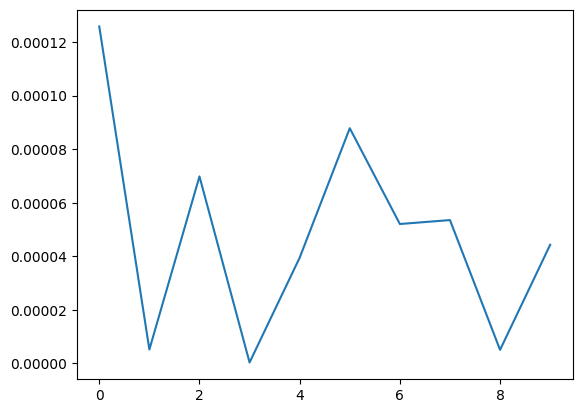

In [7]:
plt.plot(val.metric_values)
plt.show()

### Генерируем признаки для теста обученной модели

In [8]:
gen = FeaturesGenerator(r"data\configs\features\config.json")
test = gen.generate_features(test)

print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 319 to 396
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          78 non-null     datetime64[ns]
 1   value         78 non-null     float64       
 2   lag_6         78 non-null     float64       
 3   lag_12        78 non-null     float64       
 4   diff_lag_12   78 non-null     float64       
 5   diff_lag_6    78 non-null     float64       
 6   std_7         78 non-null     float64       
 7   mean_5_lag_5  78 non-null     float64       
 8   year          78 non-null     int32         
 9   month_cos     78 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int32(1)
memory usage: 6.4 KB
None


In [9]:
test = test.set_index('date')
exog = test.drop(columns=['value'])
print(exog.head())

               lag_6    lag_12  diff_lag_12  diff_lag_6      std_7  \
date                                                                 
2011-08-01  107.3753  112.9014       0.6944      6.2205   9.522285   
2011-09-01   99.1028  100.1209      -0.6497      0.3684   9.336061   
2011-10-01   89.3583   88.9251       1.4315      0.9983  10.100915   
2011-11-01   90.0698   92.7750       1.0345      3.7397   9.531628   
2011-12-01  102.8204  114.3266      -6.9954      4.5108   8.657901   

            mean_5_lag_5  year     month_cos  
date                                          
2011-08-01     102.11022  2011 -5.000000e-01  
2011-09-01     104.13280  2011 -1.836970e-16  
2011-10-01     104.19016  2011  5.000000e-01  
2011-11-01     102.38798  2011  8.660254e-01  
2011-12-01     100.91286  2011  1.000000e+00  


### Предсказываем на выборке, которую модель ещё не видела

In [10]:
predict_params = {
    'start': test.index[-48],
    'end': test.index[-1],
    'exog': exog,
}
pred = val.predict(predict_params)

print(pred.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-02-01 to 2018-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes
None


In [11]:
print(pred.head())

            prediction
2014-02-01  112.867133
2014-03-01  104.747928
2014-04-01   90.270741
2014-05-01   92.117122
2014-06-01  101.860501


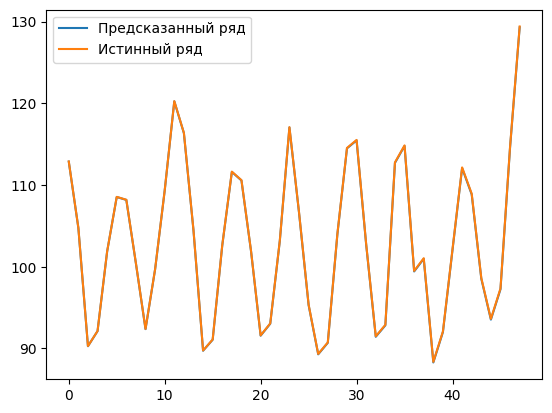

In [12]:
plt.plot(np.arange(0, 48), pred[pred.columns[0]].values[-48:], label='Предсказанный ряд')
plt.plot(np.arange(0, 48), df['value'][-48:], label='Истинный ряд')
plt.legend()
plt.show()

### Сравнение предсказанных и истинных данных

In [13]:
res = pd.DataFrame({
    'date': df['date'][-48:].values,
    'y_pred': pred[pred.columns[0]].values[-48:],
    'y_true': df['value'][-48:].values
})
print(res)

         date      y_pred    y_true
0  2014-02-01  112.867133  112.8811
1  2014-03-01  104.747928  104.7631
2  2014-04-01   90.270741   90.2867
3  2014-05-01   92.117122   92.1340
4  2014-06-01  101.860501  101.8780
5  2014-07-01  108.531459  108.5497
6  2014-08-01  108.174992  108.1940
7  2014-09-01  100.396821  100.4172
8  2014-10-01   92.362108   92.3837
9  2014-11-01   99.680181   99.7033
10 2014-12-01  109.323918  109.3477
11 2015-01-01  120.244216  120.2696
12 2015-02-01  116.351774  116.3788
13 2015-03-01  104.442154  104.4706
14 2015-04-01   89.716527   89.7461
15 2015-05-01   91.061963   91.0930
16 2015-06-01  102.617385  102.6495
17 2015-07-01  111.602062  111.6354
18 2015-08-01  110.557684  110.5925
19 2015-09-01  101.883817  101.9204
20 2015-10-01   91.557711   91.5959
21 2015-11-01   93.022824   93.0628
22 2015-12-01  103.179437  103.2203
23 2016-01-01  117.040743  117.0837
24 2016-02-01  106.623969  106.6688
25 2016-03-01   95.308254   95.3548
26 2016-04-01   89.276973   

### Значение метрики WAPE в данном случае

In [14]:
print(WAPE(res['y_true'], res['y_pred']))

0.0004677032168618354
